## Predicting Restaurant Health Inspection Scores Using Yelp Reviews

<h2 style="color: lightskyblue;">I. Introduction</h2>

The objective of our project is to apply data science techniques from our Intro to Data Science Course in order to build out models that can accurately predict health inspection outcomes for restaurants in a given area. We aim to combine Natural Language Processing of review text for sentiment analysis with structured meta data to construct these predictive models. <br><br>
In order to best explore our data, we will follow the *Knowledge Discovery from Data* approach. Namely, we seek to:
+ Clean the selected datasets to remove noise
+ Integrate and join data from  two sources (Yelp Academic Dataset and Select City Health Scores)
+ Select the relevant data from our constructed dataset for analysis
+ Transform our data into a usable form for mining
+ Mine our data to find interesting patterns
+ Evaluate our patterns based on interestingness to construct our models
+ Present our mined knowledge and models to positively impact the consumers ability to recognize safe restaurants

In [1]:
# Section I Snippet - Importing libraries to be used throughout notebook
import json
import pandas as pd
import matplotlib.pyplot as plt
import re
from thefuzz import fuzz
from thefuzz import process

<h2 style="color: lightskyblue;">II. Cleaning Selected Datasets</h2>

To clean our data sets and prepare them for joining so that we may build out our classification models, we pursue 2 tasks:
1. *Cleaning our Yelp data*
2. *Cleaning our City health inspection data*

<h3 style="color: orange;">Task 1: Cleaning Yelp Data</h3>

We begin our data analysis process by working with our Yelp dataset in JSON format in order to clean the data and bring it down to a workable size. Our selected city for analysis is Tampa as both the Yelp and Health Department data are well populated. <br><br>
**NOTE** - Due to the large size of the datasets being operated upon, we have not included them in our repository. Please visit https://www.yelp.com/dataset if you wish to run this analysis locally and ensure that the following files are placed in the raw_datasets directory after cloning.

+ *yelp_academic_dataset_business.json*
+ *yelp_academic_dataset_review.json*

In [2]:
# Task 1 Snippet A - Cleaning the Business IDs

target_city = "Tampa"
target_state = "FL"
business_ids = set()
filtered_businesses = []

with open('./raw_datasets/yelp_academic_dataset_business.json', 'r', encoding = 'utf-8') as f:
    for line in f:
        data = json.loads(line)
        if data.get('city') == target_city and data.get('state') == target_state:
            filtered_businesses.append(data)
            business_ids.add(data['business_id'])

# Save filtered businesses
with open('filtered_business.json', 'w', encoding='utf-8') as f:
    for b in filtered_businesses:
        f.write(json.dumps(b) + '\n')

**NOTE** - In your directory, you can now see the result of this script as our *filtered_business.json* file.

In [3]:
# Task 1 Snippet B - Filtering the Reviews
filtered_reviews = []

with open('./raw_datasets/yelp_academic_dataset_review.json', 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        if data['business_id'] in business_ids:
            filtered_reviews.append(data)

with open('filtered_reviews.json', 'w', encoding='utf-8') as f:
    for r in filtered_reviews:
        f.write(json.dumps(r) + '\n')

**NOTE** - In your directory, you can now see the result of this script as our *filtered_reviews.json* file.

In [4]:
# Task 1 Snippet C - Importing reviews and business IDs as a data frame to clean unused columns

def load_json_lines(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return pd.DataFrame([json.loads(line) for line in f])

business_df = load_json_lines('filtered_business.json')
review_df = load_json_lines('filtered_reviews.json')

# Join on business_id
combined_df = review_df.merge(business_df, on='business_id', suffixes=('_review', '_business'))

combined_df[['stars_review', 'text', 'name', 'categories']].head()

,stars_review,text,name,categories
0,5.0,My experience with Shalimar was nothing but wo...,Shalimar Fine Jewelers,"Shopping, Jewelry"
1,4.0,"Very helpful and patient. 20"" 14k gold chain ...",Shalimar Fine Jewelers,"Shopping, Jewelry"
2,5.0,They were all very easy to work with and went ...,Shalimar Fine Jewelers,"Shopping, Jewelry"
3,1.0,They have forever lost my business. Ordered a ...,Shalimar Fine Jewelers,"Shopping, Jewelry"
4,1.0,please dont go here they have bullshit gold th...,Shalimar Fine Jewelers,"Shopping, Jewelry"


In [5]:
# Task 1 Snippet D - Refining the schema of the combined_df
print(combined_df.columns)
combined_df_refined = combined_df[['business_id', 'stars_review', 'text', 'address', 'categories', 'name',]]

Index(['business_id', 'cool', 'date', 'funny', 'review_id', 'stars_review',
       'text', 'useful', 'user_id', 'address', 'attributes', 'categories',
       'city', 'hours', 'is_open', 'latitude', 'longitude', 'name',
       'postal_code', 'review_count', 'stars_business', 'state'],
      dtype='object')


**NOTE** - From the above, we can see that even in our combined and refined data frame, we are still holding onto data points we do not wish to assess. Nominally, we must only include those categories of business that have food in the category.

In [6]:
# Task 1 Snippet E - Generating final tampa_review_df
tampa_review_df = ( combined_df_refined[combined_df_refined['categories'].str.contains('Food', na=False)] \
                   .drop(columns=['categories']) )
tampa_review_df.head()

,business_id,stars_review,text,address,name
280,cg4JFJcCxRTTMmcg9O9KtA,1.0,Skip this train wreck if you are looking for d...,718 S Howard Ave,Ava
281,cg4JFJcCxRTTMmcg9O9KtA,4.0,This was my first time dining at Ava and I enj...,718 S Howard Ave,Ava
282,cg4JFJcCxRTTMmcg9O9KtA,5.0,Amazing dinner. What a unique menu. The serv...,718 S Howard Ave,Ava
283,cg4JFJcCxRTTMmcg9O9KtA,1.0,We went for lunch on Saturday. They only serv...,718 S Howard Ave,Ava
284,cg4JFJcCxRTTMmcg9O9KtA,2.0,I order the bone in ribeye fit market value. T...,718 S Howard Ave,Ava


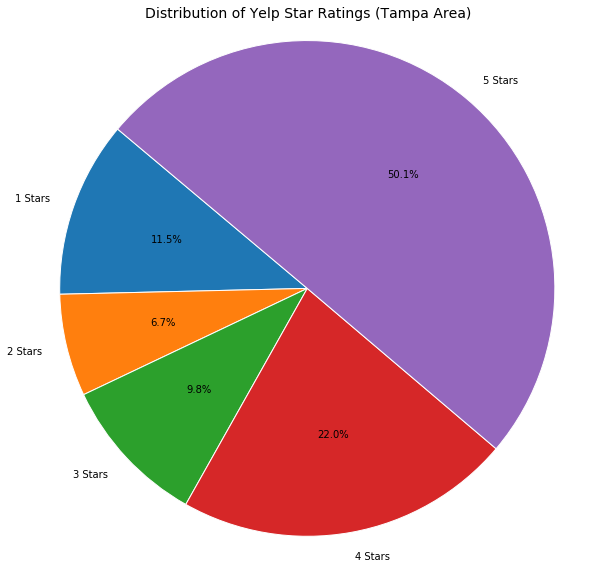

In [7]:
# Task 1 Snippet F - Visual of Star Distribution
%matplotlib inline
grouped = tampa_review_df.groupby('stars_review').size()

# Plot
plt.figure(figsize=(8, 8))
plt.pie(
    grouped,
    labels=[f"{int(star)} Stars" for star in grouped.index],
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}
)
plt.title("Distribution of Yelp Star Ratings (Tampa Area)", fontsize=14)
plt.axis('equal')  # Keep it a circle
plt.tight_layout()
plt.show()

<h3 style="color: orange;">Task 2: Cleaning Tampa Health Data</h3>

Our data analysis and exploration of our Tampa Health Data begins by importing the statewide food service inspections for fiscal year 2022-2023 as this is what the Yelp dataset covers up to.  <br><br>
**NOTE** - Due to the large size of the datasets being operated upon, we have not included them in our repository. Please visit https://www2.myfloridalicense.com/hotels-restaurants/public-records/#1506344763000-101d4ee5-7a59 if you wish to run this analysis locally and ensure that the following file is placed in the raw_datasets directory after cloning. You may have to convert it from .xlsx to .csv

+ *fdinspi_2223.csv*

In [8]:
# Task 2 Snippet A - Importing our Tampa Health Data
health_df = pd.read_csv("./raw_datasets/fdinspi_2223.csv")
health_df.columns

Index(['DISTRICT', 'COUNTYCODE', 'CNTY_DESC', 'PROFESSION', 'LICENSE_NO',
       'DBA_NAME', 'LOC_ADDRESS', 'LOC_CITY', 'LOC_ZIP', 'INSP_NO', 'VISIT_NO',
       'INSPCLASS', 'INSPTYPE', 'DISPOSITION', 'INSP_DATE', 'CRIT_VIOL',
       'NONCRIT_VIOL', 'VIOLATIONS', 'HIGH_VIOL', 'INTERMED_VIOL',
       'BASIC_VIOL', 'HT_VIOL', 'PDA', 'V_01', 'V_02', 'V_03', 'V_04', 'V_05',
       'V_06', 'V_07', 'V_08', 'V_09', 'V_10', 'V_11', 'V_12', 'V_13', 'V_14',
       'V_15', 'V_16', 'V_17', 'V_18', 'V_19', 'V_20', 'V_21', 'V_22', 'V_23',
       'V_24', 'V_25', 'V_26', 'V_27', 'V_28', 'V_29', 'V_30', 'V_31', 'V_32',
       'V_33', 'V_34', 'V_35', 'V_36', 'V_37', 'V_38', 'V_39', 'V_40', 'V_41',
       'V_42', 'V_43', 'V_44', 'V_45', 'V_46', 'V_47', 'V_48', 'V_49', 'V_50',
       'V_51', 'V_52', 'V_53', 'V_54', 'V_55', 'V_56', 'V_57', 'V_58',
       'LIC_ID', 'INSP_VST_ID'],
      dtype='object')

As we can see from above, we have a ton of violation codes and other extraneous information that we do not need. To make the dataset more manageable to work with, we select only those columns with information about the violation levels, business name, and address so that we can join this with our review information.

In [9]:
# Task 2 Snippet B - Selecting our useful features and filtering by city
tampa_health_df = health_df[health_df['LOC_CITY'] == 'TAMPA']
tampa_health_selected_df = tampa_health_df[['DBA_NAME', 'LOC_ADDRESS', 'HIGH_VIOL', 'INTERMED_VIOL', 'BASIC_VIOL']]

In [10]:
tampa_health_selected_df.head()

,DBA_NAME,LOC_ADDRESS,HIGH_VIOL,INTERMED_VIOL,BASIC_VIOL
29,SWEET TEA TIKI BAR,4601 N LOIS AVE,0.0,0.0,0.0
51,COUNTRYWAY GOLF CLUB,11111 WATERS AVE,0.0,1.0,1.0
111,CHARS JAMAICAN KITCHEN,5224 S DALE MABRY HWY,0.0,0.0,0.0
180,SABROSITO'S LLC,5011 W HILLSBOROUGH AVE STE A,0.0,3.0,4.0
249,DOMINO'S PIZZA,7104 EAST FOWLER AVENUE,0.0,0.0,0.0


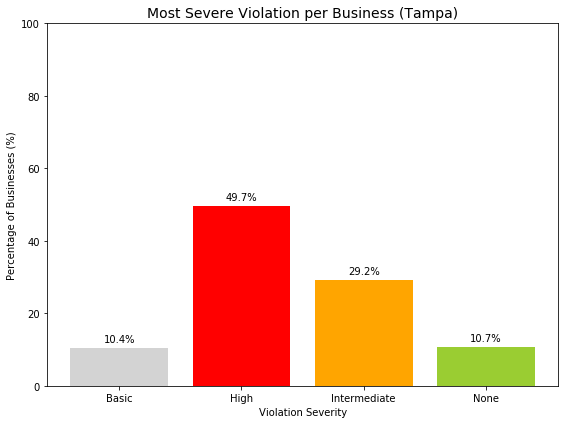

In [11]:
# Task 2 Snippet C - Visualizing Violation Severity
def classify_violation(row):
    if row['HIGH_VIOL'] > 0:
        return 'High'
    elif row['INTERMED_VIOL'] > 0:
        return 'Intermediate'
    elif row['BASIC_VIOL'] > 0:
        return 'Basic'
    else:
        return 'None'

# Apply classification
tampa_health_selected_df = tampa_health_selected_df.copy()
tampa_health_selected_df.loc[:, 'Violation_Level'] = tampa_health_selected_df.apply(classify_violation, axis=1)

# Get counts and plot
violation_counts = tampa_health_selected_df['Violation_Level'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))
bars = plt.bar(violation_counts.index, violation_counts.values, color=['red', 'orange', 'yellowgreen', 'lightgray'])
plt.title('Most Severe Violation per Business (Tampa)', fontsize=14)
plt.ylabel('Percentage of Businesses (%)')
plt.xlabel('Violation Severity')
plt.ylim(0, 100)

# Add percentage labels on top
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

<h3 style="color: orange;">Cleaning Datasets Summary</h3>

From our data exploration above, we can see 4 distinct classes of food service businesses emerge. These classes will help us better develop classifier models and, from what we have observed, serve the user of our models better than trying to distinguish between a binary *Pass / Fail* criteria. None of the health inspection data we have seen so clearly labels a business as passing or failing, so instead we seek to classify restaurants as follows:

+ Likely to commit a Severe Violation
+ Likely to commit an Moderate Violation
+ Likely to commit a Basic Violation
+ Not likely to commit a violation

<h2 style="color: lightskyblue;">III. Integrating and Joining Data</h2>

Integrating and joining our data should be relatively straight-forward now that we have scaled our dataframes down to a more manageable size. We will again perform two tasks for this section:
1. *Group By and Aggregation on each dataframe*  
2. *Joining the dataframes together*

<h3 style="color: orange;">Task 1: Group By and Aggregation</h3>


In [12]:
# Task 1 Snippet A - Group By and Aggregation over tampa_review_df
aggregated_review_df = tampa_review_df.groupby('business_id').agg({
    'stars_review': 'mean',
    'text': ' '.join,
    'address': 'first',
    'name': 'first'
}).rename(columns={
    'stars_review': 'avg_stars',
    'text': 'all_reviews'
}).reset_index()
print(f"Original row count: {len(tampa_review_df)}")
print(f"Original row count: {len(aggregated_review_df)}")

Original row count: 148685
Original row count: 2034


In [13]:
# Task 1 Snippet B - Group By and Aggregation over tampa_health_selected_df
severity_order = {
    'High': 3,
    'Intermediate': 2,
    'Basic': 1,
    'None': 0
}
tampa_health_selected_df['Severity_Score'] = tampa_health_selected_df['Violation_Level'].map(severity_order)

original_count = len(tampa_health_selected_df)
print("Original row count:", original_count)

max_severity_idx = tampa_health_selected_df.groupby(['DBA_NAME', 'LOC_ADDRESS'])['Severity_Score'].idxmax()

aggregated_health_df = tampa_health_selected_df.loc[max_severity_idx]
new_count = len(aggregated_health_df)
print("Aggregated row count:", new_count)

Original row count: 6360
Aggregated row count: 2977


<h3 style="color: orange;">Task 2: Joining the Dataframes</h3>

To join our dataframes, aggregated_review_df and aggregated_health_df, we need to first figure out how the addresses and business names are formatted. Following that we will apply some sort of fuzzy finding to get our final dataset to build our models with.

In [14]:
# Task 2 Snippet A - Reviewing Dataframe Formats
print(aggregated_review_df.head())
print(aggregated_health_df.head())

              business_id  avg_stars  \
0  --rS-rnOIZxoiDA8yctWpQ   5.000000   
1  -1oygVebK81K8JEPI6H6Lw   3.986667   
2  -2CPhK6ik9ZBgFX_F-dkxQ   1.800000   
3  -2dvQxx3cYXd5XmFdDDsDA   2.370370   
4  -2wh7NTLkWEgsrLJvilnFQ   4.416667   

                                         all_reviews  \
0  Recommended by friends, we walked across the s...   
1  Checked in, then checked out disappointed :( A...   
2  Just your typical subway. This one is particul...   
3  Worst (weak, watery 'Americanized & somehow bi...   
4  The lamb gyro sandwich was cold once I receive...   

                          address                                   name  
0              555 Channelside Dr                Publix GreenWise Market  
1              501 E Kennedy Blvd                      Bruegger's Bagels  
2  14961 N Florida Ave, Ste 14961                                 Subway  
3         4100 George J Bean Pkwy                             illy Caffè  
4              8896 N Florida Ave  Istanbul Med

In [15]:
# Task 2 Snippet B - Fuzzy Finding and Joining the Dataframes
def clean_string(s):
    return re.sub(r'[^a-zA-Z0-9 ]', '', str(s).lower().strip())

aggregated_review_df['match_key'] = ( aggregated_review_df['name'].apply(clean_string) + ' ' 
                                     + aggregated_review_df['address'].apply(clean_string) )
aggregated_health_df['match_key'] = ( aggregated_health_df['DBA_NAME'].apply(clean_string) + ' '
                                     + aggregated_health_df['LOC_ADDRESS'].apply(clean_string) )

# Map closest health entry for each review entry
matches = []

# Goes through every row in the review_df comparing to each row in health_df
for i, row in aggregated_review_df.iterrows():
    match_string, score, _ = process.extractOne(
        row['match_key'], 
        aggregated_health_df['match_key'], 
        scorer=fuzz.token_set_ratio
    )
    
    if score >= 90:  # tune this threshold if needed
        matched_row = aggregated_health_df[aggregated_health_df['match_key'] == match_string].iloc[0]
        combined_row = row.to_dict()
        for col in ['Violation_Level', 'Severity_Score', 'HIGH_VIOL', 'INTERMED_VIOL', 'BASIC_VIOL', 'DBA_NAME', 'LOC_ADDRESS']:
            combined_row[col] = matched_row[col]
        matches.append(combined_row)

training_df = pd.DataFrame(matches)

In [16]:
print(len(training_df))
print(training_df.head())

632
   BASIC_VIOL                DBA_NAME  HIGH_VIOL  INTERMED_VIOL  \
0         2.0       BRUEGGER'S BAGELS        1.0            2.0   
1         3.0             ILLY CAFE E        0.0            2.0   
2         9.0  ISTANBUL MEDITERRANEAN        0.0            3.0   
3         0.0         CLEAN JUICE BAR        0.0            1.0   
4         5.0         PIZZA HUT #4666        0.0            0.0   

                                         LOC_ADDRESS  Severity_Score  \
0                              501 EAST KENNEDY BLVD               3   
1  4100 GEORGE J BEAN PKWY, TAMPA INTERNATIONAL A...               2   
2                              8896 N FLORIDA AVENUE               2   
3                             13138 N DALE MABRY HWY               2   
4                                    5263 EHRLICH RD               1   

  Violation_Level                  address  \
0            High       501 E Kennedy Blvd   
1    Intermediate  4100 George J Bean Pkwy   
2    Intermediate     

<h2 style="color: lightskyblue;">IV. Selecting Relevant Features</h2>

For this section, we will justify our decisions in dropping certain features during our data cleaning process as well as justify our final features that we have selected for model building.

In [17]:
# Section IV Snippet A - Our original dataframe columns after importing
print(combined_df.columns)
print(health_df.columns)

Index(['business_id', 'cool', 'date', 'funny', 'review_id', 'stars_review',
       'text', 'useful', 'user_id', 'address', 'attributes', 'categories',
       'city', 'hours', 'is_open', 'latitude', 'longitude', 'name',
       'postal_code', 'review_count', 'stars_business', 'state'],
      dtype='object')
Index(['DISTRICT', 'COUNTYCODE', 'CNTY_DESC', 'PROFESSION', 'LICENSE_NO',
       'DBA_NAME', 'LOC_ADDRESS', 'LOC_CITY', 'LOC_ZIP', 'INSP_NO', 'VISIT_NO',
       'INSPCLASS', 'INSPTYPE', 'DISPOSITION', 'INSP_DATE', 'CRIT_VIOL',
       'NONCRIT_VIOL', 'VIOLATIONS', 'HIGH_VIOL', 'INTERMED_VIOL',
       'BASIC_VIOL', 'HT_VIOL', 'PDA', 'V_01', 'V_02', 'V_03', 'V_04', 'V_05',
       'V_06', 'V_07', 'V_08', 'V_09', 'V_10', 'V_11', 'V_12', 'V_13', 'V_14',
       'V_15', 'V_16', 'V_17', 'V_18', 'V_19', 'V_20', 'V_21', 'V_22', 'V_23',
       'V_24', 'V_25', 'V_26', 'V_27', 'V_28', 'V_29', 'V_30', 'V_31', 'V_32',
       'V_33', 'V_34', 'V_35', 'V_36', 'V_37', 'V_38', 'V_39', 'V_40', 'V_41',
    

<h3 style="color: orange;">Dropped Features</h3>

In our combined_df, which represents the business and review information, we are able to drop:

+ Those features related to location which we have already set filters on to narrow down to just Tampa:

$$
\text{categories, city, latitude, longitude, postal_code, state}
$$

+ Those features which have to do with internal metrics at Yelp / reactions to user reviews:

$$
\text{cool, funny, review_id, useful, user_id, stars_business, review_count, date}
$$

+ And those features which deal with business attributes:

$$
\text{hours, is_open, attributes}
$$

From these drops, we have only those columns left which will help us to identify the business and assess the likelihood of the business doing well or poorly on a health inspection.
<br>

In our health_df, which represents the results of health inspections, we are able to drop:

+ All those features related to location which we do not need to join the dataset with the yelp review information.
+ All of the health inspection office specific information. Violation codes, disposition, visit id, etc.

We note that, in exploring the data as it came (.xlsx format) from the health department, we found that certain columns were completely unused ('CRIT_VIOL' for example). 

<h3 style="color: orange;">Plausible Features Not Selected</h3>

Worth discussing in a separate section are the features that were dropped above that may contribute to a more comprehensive model for researchers looking to investigate beyond NLP sentiment analysis and basic classification.

In our combined_df:

+ We acknowledge that latitude, longitude, and location information may contribute to a model that identifies pockets of likely violators geographically.
+ Business hours and attributes like "accepts credit cards" may also indicate a more modern business / business that is more likely to maintain cleanliness.

However, for our simple model constructions we are satisfied with stars and the corpus of review text we have.
<br>

In our health_df:

+ The individual health inspection codes may help in classifying the businesses

While it is beyond the scope of this project to look all of the codes up and import them, we do recognize that these individual codes may benefit model training.

In [18]:
# Section IV Snippet B - Final Feature Selection
print(training_df.columns)
final_training_set = training_df[['name', 'avg_stars', 'all_reviews', 'Severity_Score']]
print(final_training_set.head())

Index(['BASIC_VIOL', 'DBA_NAME', 'HIGH_VIOL', 'INTERMED_VIOL', 'LOC_ADDRESS',
       'Severity_Score', 'Violation_Level', 'address', 'all_reviews',
       'avg_stars', 'business_id', 'match_key', 'name'],
      dtype='object')
                                    name  avg_stars  \
0                      Bruegger's Bagels   3.986667   
1                             illy Caffè   2.370370   
2  Istanbul Mediterranean Grill & Market   4.416667   
3                Clean Juice Carrollwood   3.915789   
4                              Pizza Hut   2.857143   

                                         all_reviews  Severity_Score  
0  Checked in, then checked out disappointed :( A...               3  
1  Worst (weak, watery 'Americanized & somehow bi...               2  
2  The lamb gyro sandwich was cold once I receive...               2  
3  Enjoyed both smoothies I had over the past few...               2  
4  I just had delivery from this location.  I am ...               1  


<h2 style="color: lightskyblue;">V. Data Transformation</h2>

In order to mine interesting patterns from our dataset and construct models from those patterns that present themselves, we must transform our data into a more usable form. Specifically, we want to explore the review data in a bit more detail and examine the prevalence of positive / negative reviews in our data set. For our first 2 tasks, we seek to classify reviews as good or bad. For our third task, we apply TF-IDF and combine our extracted features with our avg_stars feature to give us a single feature matrix. 
1. *Review Exploration and Good Reviews* 
2. *Bad Reviews and Classification of Reviews*
3. *TF-IDF and Feature Matrix Construction*

<h3 style="color: orange;">Task 1: Review Exploration and Good Reviews</h3>


In [ ]:
# Task 1 Snippet A - Construction of Reviews dataframe
reviews = pd.DataFrame(filtered_reviews)
reviews.date = pd.to_datetime(reviews.date)
print("The first recorded date:", reviews.date.min())
print("The most recent date:", reviews.date.max())

In [ ]:
# Task 1 Snippet B - Good Reviews
import nltk

nltk.download('punkt')

positive_keywords = {'good', 'great', 'excellent', 'amazing', 'awesome', 'fantastic', 'love', 'wonderful', 'best'}

def get_good_reviews(tokens):
    tokens_lower = [t.lower() for t in tokens]
    return any(word in tokens_lower for word in positive_keywords)

good_reviews = []
rev_count = 0

with open('filtered_reviews.json', 'r', encoding='utf-8') as fin:
    for line in fin:
        rev_count += 1
        review = json.loads(line)
        text = review.get('text', '')
        tokens = nltk.word_tokenize(text)
        if get_good_reviews(tokens):
            good_reviews.append(review)

# Print or save good_reviews as needed
print(f'Total Reviews: {rev_count}')
print(f'Number of good reviews: {len(good_reviews)}')

<h3 style="color: orange;">Task 2: Bad Reviews and Classification of Reviews</h3>


In [ ]:
# Task 2 Snippet A - Bad Reviews
negative_keywords = {'bad', 'terrible', 'awful', 'worst', 'poor', 'disappointing', 'horrible', 'hate', 'boring', 'mediocre'}

def get_bad_review(tokens):
    tokens_lower = [t.lower() for t in tokens]
    return any(word in tokens_lower for word in negative_keywords)

bad_reviews = []

with open('filtered_reviews.json', 'r', encoding='utf-8') as fin:
    for line in fin:
        review = json.loads(line)
        text = review.get('text', '')
        tokens = nltk.word_tokenize(text)
        if get_bad_review(tokens):
            bad_reviews.append(review)

# Print or save bad_reviews as needed
print(f'Number of bad reviews: {len(bad_reviews)}')

In [ ]:
# Task 2 Snippet B - Classifying Reviews
positive_keywords = {'good', 'great', 'excellent', 'amazing', 'awesome', 'fantastic', 'love', 'wonderful', 'best'}
negative_keywords = {'bad', 'terrible', 'awful', 'worst', 'poor', 'disappointing', 'horrible', 'hate', 'boring', 'mediocre'}

def classify_review(tokens):
    tokens_lower = [t.lower() for t in tokens]
    if any(word in tokens_lower for word in positive_keywords):
        return 'good'
    elif any(word in tokens_lower for word in negative_keywords):
        return 'bad'
    else:
        return 'neutral'

classified_reviews = []

with open('filtered_reviews.json', 'r', encoding='utf-8') as fin:
    for line in fin:
        review = json.loads(line)
        text = review.get('text', '')
        tokens = nltk.word_tokenize(text)
        label = classify_review(tokens)
        review['label'] = label
        classified_reviews.append(review)

# Save classified reviews to a new file
with open('classified_reviews.json', 'w', encoding='utf-8') as fout:
    for review in classified_reviews:
        fout.write(json.dumps(review) + '\n')


<h3 style="color: orange;">Task 3: TF-IDF and Feature Matrix Construction</h3>


In [19]:
# Task 3 Snippet A - TF/IDF to extract text features from reviews
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', max_features=1000, ngram_range=(1, 2))
X_text = tfidf.fit_transform(final_training_set['all_reviews'])

In [20]:
# Task 3 Snippet B - Construction of Feature Matrix
from scipy.sparse import hstack
import numpy as np

X_stars = final_training_set['avg_stars'].values.reshape(-1, 1)
X = hstack([X_text, X_stars])
y = final_training_set['Severity_Score']

<h2 style="color: lightskyblue;">VI. Data Mining</h2>

From our Data Transformation section, we explored the presence of negative and positive words to classify review sentiment. We now take these mined patterns and apply them to add features to our feature matrix.
1. *Adding Negative Word Feature*  
2. *Adding Positive Word Feature*

<h3 style="color: orange;">Task 1: Adding Negative Word Feature</h3>


In [21]:
# Task 1 Snippet A - Negative word feature
negative_keywords = [
    'bad', 'terrible', 'awful', 'worst', 'poor',
    'disappointing', 'horrible', 'hate', 'boring', 'mediocre'
]

def contains_negative_words(text, keywords):
    text = text.lower()
    return int(any(word in text for word in keywords))

final_training_set['has_negative_words'] = final_training_set['all_reviews'].apply(
    lambda x: contains_negative_words(x, negative_keywords)
)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


<h3 style="color: orange;">Task 2: Adding Positive Word Feature</h3>


In [22]:
# Task 2 Snippet A - Positive word feature
positive_keywords = [
    'good', 'great', 'excellent', 'amazing', 'awesome',
    'fantastic', 'love', 'wonderful', 'best'
]

def contains_positive_words(text, keywords):
    text = text.lower()
    return int(any(word in text for word in keywords))

final_training_set['has_positive_words'] = final_training_set['all_reviews'].apply(
    lambda x: contains_positive_words(x, positive_keywords)
)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [23]:
# Task 2 Snippet B - Constructing Final Feature Matrix
X_neg = final_training_set['has_negative_words'].values.reshape(-1, 1)
X_pos = final_training_set['has_positive_words'].values.reshape(-1, 1)
XFinal = hstack([X_text, X_stars, X_neg, X_pos])

<h2 style="color: lightskyblue;">VII. Pattern Evaluation and Model Construction</h2>

We will be constructing three models to evaluate our patterns and model our problem:
1. *Logistic Regression*  
2. *Random Forest*
3. *Naive Bayes (Multinomial)*

<h3 style="color: orange;">Task 1: Logistic Regression</h3>


In [24]:
# Task 1 Snippet A - Importing sklearn modules and setting up training
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    XFinal, final_training_set['Severity_Score'], test_size=0.2, random_state=42
)


In [25]:
# Task 1 Snippet B - Logistic Regression model construction
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

print("Logistic Regression")
print(classification_report(y_test, y_pred_logreg))

Logistic Regression
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         2
          1       0.00      0.00      0.00         5
          2       0.00      0.00      0.00        29
          3       0.72      1.00      0.84        91

avg / total       0.52      0.72      0.60       127



/usr/lib/python3/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<h3 style="color: orange;">Task 2: Random Forest</h3>


In [26]:
# Task 2 Snippet A - Random Forest training setup
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

In [27]:
# Task 2 Snippet B - Random Forest Model construction
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_dense, y_train)
y_pred_rf = rf.predict(X_test_dense)

print("Random Forest")
print(classification_report(y_test, y_pred_rf))


Random Forest
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         2
          1       0.00      0.00      0.00         5
          2       0.50      0.03      0.06        29
          3       0.72      0.99      0.83        91

avg / total       0.63      0.72      0.61       127



/usr/lib/python3/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<h3 style="color: orange;">Task 3: Naive Bayes</h3>


In [28]:
# Task 3 Snippet A - Naive Bayes model construction
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("Naive Bayes")
print(classification_report(y_test, y_pred_nb))

Naive Bayes
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         2
          1       0.00      0.00      0.00         5
          2       0.00      0.00      0.00        29
          3       0.72      1.00      0.83        91

avg / total       0.51      0.72      0.60       127



/usr/lib/python3/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<h2 style="color: lightskyblue;">VIII. Model Performance and Analysis</h2>

To assess our model performance, we display the confusion matrices for each model and have found that the Random Forest is the best model as it is more robust to feature interactions and improved recall slightly on Class 2. <br>
Future improvements could be made to our basic model construction here in the form of resampling strategies, additional features to add to our feature matrix, and more robust modeling and classification methods.

In [29]:
# Section VIII Snippet A - Confusion Matrix Plotting Function
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    classes = sorted(np.unique(y_true))
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap='Blues')

    # Show labels
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.title(f"Confusion Matrix: {title}")

    # Annotate cells
    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

    plt.colorbar(im)
    plt.tight_layout()
    plt.show()


Logistic Regression
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         2
          1       0.00      0.00      0.00         5
          2       0.00      0.00      0.00        29
          3       0.72      1.00      0.84        91

avg / total       0.52      0.72      0.60       127



/usr/lib/python3/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


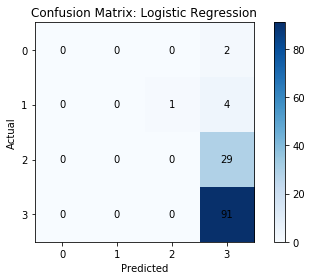

Random Forest
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         2
          1       0.00      0.00      0.00         5
          2       0.50      0.03      0.06        29
          3       0.72      0.99      0.83        91

avg / total       0.63      0.72      0.61       127



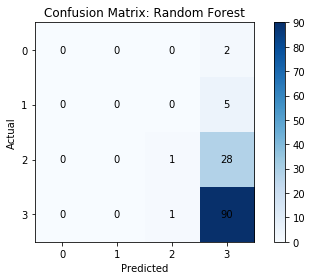

Naive Bayes
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         2
          1       0.00      0.00      0.00         5
          2       0.00      0.00      0.00        29
          3       0.72      1.00      0.83        91

avg / total       0.51      0.72      0.60       127



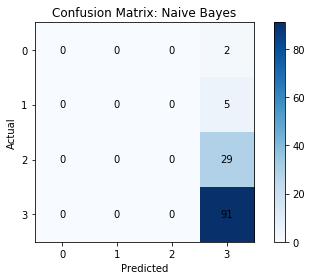

In [30]:
# Section VIII Snippet B - Model Evaluation through Confusion Matrix Plotting
print("Logistic Regression")
print(classification_report(y_test, y_pred_logreg))
plot_confusion_matrix(y_test, y_pred_logreg, "Logistic Regression")

print("Random Forest")
print(classification_report(y_test, y_pred_rf))
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")

print("Naive Bayes")
print(classification_report(y_test, y_pred_nb))
plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes")

